In [57]:
# "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection
# Copyright (C) 2024 TU Dresden, Center for Information Services and High Performance Computing
#
# This file is part of the "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection.
#
# The "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
#
# The "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with "Energy Efficiency Features of the Intel Alder Lake Architecture" Artifact Collection. If not, see <https://www.gnu.org/licenses/>.

In [58]:
import tarfile
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
import numpy as np
from pylab import rcParams
from scipy.fftpack import fft2, fftfreq
from matplotlib.colors import ListedColormap
import glob


In [59]:
# loads the results
# stores: localities: a list of remote active, local, remote
#         state: the C-state. 0->POLL, 1->C1(E), 2->C6, 3->C8, 4->C10
#         frequencies: a list of frequencies that were tested
#         results. a dict of [locality][state][frequency]

# get local, cstates and frequencies

prog = re.compile(r'.*perf\.data\.([a-z_]+)_callee\.state(\d+)\.(\d+)\.(\d+)\.(\d+)')

caller_prog= re.compile(r'^\s+cond_wait\s+\d+\s+\[\d+\]\s+(.+):\s+sched:sched_waking\:.+cpu=(\d+)$')

callee_prog= re.compile(r'^\s+\S+\s+\d+\s+\[\d+\]\s+(.+):\s+power:cpu_idle\:\s*state\=(\d+).+$')

frequencies=[]
localities={}
states=[]

file_names=[]

# Iterate through each member and read its content line by line
for file_name in glob.glob('../test/data_txt/perf.data*'):
    file_names.append(file_name)

print(file_names)

for f in file_names:
    result = prog.match(f)
    if result == None:
        continue
    if result.group(1) not in localities:
        localities[result.group(1)]=[result.group(4),result.group(5)]
    if int(result.group(3)) not in frequencies:
        frequencies.append(int(result.group(3)))
    if int(result.group(2)) not in states:
        states.append(int(result.group(2)))
frequencies=sorted(frequencies)
states=sorted(states)

print(frequencies)
print(states)
#print (localities)

# get caller / callee
results={}
for locality in localities:
#    print(locality)
    results[locality]={}
    for state in states:
        results[locality][state]={}
        for frequency in sorted(frequencies):
#            print(locality,state,frequency)
            results[locality][state][frequency]={}
            # get the two files from file_names
            for s in ['caller','callee']:
                x = [f for f in file_names if 'perf.data.'+locality+'_'+s+'.state'+str(state) + '.'+str(frequency) in f ]
                results[locality][state][frequency][s]=x[0]
            # parse caller/callee
            caller_content=open(results[locality][state][frequency]['caller'], 'rb').readlines()
            results[locality][state][frequency]['times']=[]
            callee_content=open(results[locality][state][frequency]['callee'], 'rb').readlines()
            callee_times=[]
            callee_states=[]
            for callee_b_line in callee_content:
                callee_line=callee_b_line.decode('utf-8')
                result = callee_prog.match(callee_line)
                if result == None:
                    continue
                else:
                    callee_times.append(float(result.group(1)))
                    callee_states.append(int(result.group(2)))
            last_index=0
            for line_b in caller_content:
                line=line_b.decode('utf-8')
                # parse the line
                result = caller_prog.match(line)
                if result == None:
                    continue
                if int(result.group(2)) != int(localities[locality][1]):
                    continue
                caller_time=float(result.group(1))
                last_time=caller_time
                # find the next time in callee
                for callee_time_index in range(last_index,len(callee_times)):
                    callee_time=callee_times[callee_time_index]
                    if callee_time >= caller_time:
                        last_index=callee_time_index
                        results[locality][state][frequency]['times'].append((callee_time-caller_time)*1000000)
                        break
                results[locality][state][frequency]['times']

['../test/data_txt/perf.data.local_caller.state2.1400000.0.1', '../test/data_txt/perf.data.local_caller.state2.1600000.0.1', '../test/data_txt/perf.data.local_callee.state1.1100000.0.1', '../test/data_txt/perf.data.local_caller.state1.1900000.0.1', '../test/data_txt/perf.data.local_caller.state0.1700000.0.1', '../test/data_txt/perf.data.local_caller.state0.1100000.0.1', '../test/data_txt/perf.data.local_callee.state0.1600000.0.1', '../test/data_txt/perf.data.local_callee.state0.1100000.0.1', '../test/data_txt/perf.data.local_caller.state0.2000000.0.1', '../test/data_txt/perf.data.local_caller.state2.1300000.0.1', '../test/data_txt/perf.data.local_callee.state3.1900000.0.1', '../test/data_txt/perf.data.local_callee.state1.1800000.0.1', '../test/data_txt/perf.data.local_caller.state3.800000.0.1', '../test/data_txt/perf.data.local_callee.state1.1400000.0.1', '../test/data_txt/perf.data.local_callee.state3.1400000.0.1', '../test/data_txt/perf.data.local_caller.state0.1600000.0.1', '../test

/tmp/ipykernel_71608/1048116749.py:13: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)
/tmp/ipykernel_71608/1048116749.py:20: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),


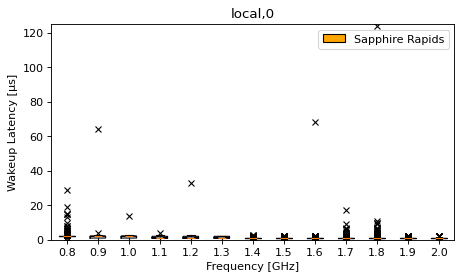

/tmp/ipykernel_71608/1048116749.py:13: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)
/tmp/ipykernel_71608/1048116749.py:20: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),


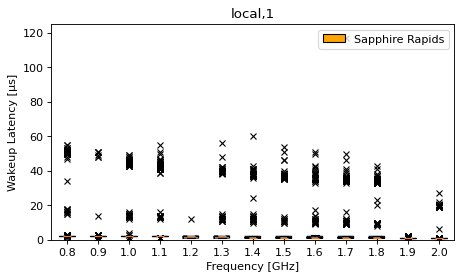

/tmp/ipykernel_71608/1048116749.py:13: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)
/tmp/ipykernel_71608/1048116749.py:20: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),


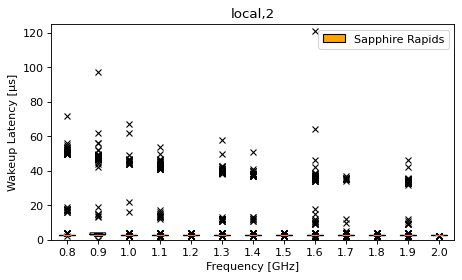

/tmp/ipykernel_71608/1048116749.py:13: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)
/tmp/ipykernel_71608/1048116749.py:20: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),


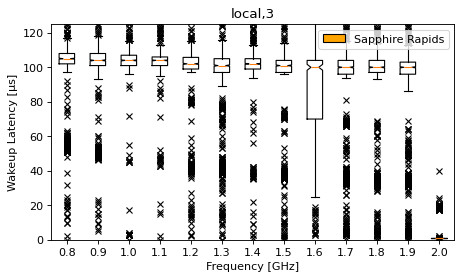

Done


In [ ]:
#prints boxplots for each test (locality, state) over frequencies
from matplotlib.pyplot import figure
from matplotlib.patches import Patch

for state in sorted(states):
    for locality in sorted(localities):
        figure(num=None, figsize=(6.5, 3.5), dpi=80, facecolor='w', edgecolor='k')
        lists=[]
        xs=[]
        for frequency in sorted(frequencies):
            lists.append(results[locality][state][frequency]['times'])
            xs.append(frequency/1000000.0)
        plt.boxplot(lists,xs,sym='x') #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        lists=[]
        for frequency in sorted(frequencies):
            lists.append((0.0));
        c='#BBBBBB'
        plt.rcParams['pdf.fonttype'] = 42
        plt.boxplot(lists,xs,sym='x',patch_artist=True, boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c)) #,points=1000, widths=0.2, showmeans=True,showextrema=False, showmedians=True)

        legend_elements = [
                       Patch(facecolor='orange', edgecolor='black',
                             label='Sapphire Rapids')]

        plt.legend(handles=legend_elements, loc='upper right')
        plt.ylim([0,125])
        plt.xticks(range(1,len(xs)+1),xs)
        plt.xlabel("Frequency [GHz]")
        plt.ylabel(r'Wakeup Latency [µs]')
        plt.title(locality+','+str(state))
        plt.show()
   
print("Done")

In [61]:
print(results)

{'local': {0: {800000: {'caller': '../test/data_txt/perf.data.local_caller.state0.800000.0.1', 'callee': '../test/data_txt/perf.data.local_callee.state0.800000.0.1', 'times': [1.00000761449337, 2.00001522898674, 2.00001522898674, 2.00001522898674, 0.0, 2.00001522898674, 1.00000761449337, 2.00001522898674, 1.00000761449337, 2.00001522898674, 1.00000761449337, 0.9999494068324566, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 28.999987989664078, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 1.9999570213258266, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 1.9999570213258266, 1.9999570213258266, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 2.00001522898674, 1.9999570213258266, 1.9999570213258266, 2.00001522898

In [62]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [72]:
from pylab import rcParams
_frequency = "Frequency [GHz]"
_time = "Latency [μs]"
df_data = list()
print(frequencies)
for state in sorted(states):
    for locality in sorted(localities):
        for frequency in frequencies:
            for t in results[locality][state][frequency]['times']:
                df_data.append({
                    "state": state,
                    "locality": "Local" if (locality == "local") else "unknown",
                    "frequency": frequency,
                    _frequency: frequency / 1000000,
                    _time: t
                })

df = pd.DataFrame(df_data)
df = df[df[_time]<200]

print(df)

[800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000]
       state locality  frequency  Frequency [GHz]  Latency [μs]
0          0    Local     800000              0.8      1.000008
1          0    Local     800000              0.8      2.000015
2          0    Local     800000              0.8      2.000015
3          0    Local     800000              0.8      2.000015
4          0    Local     800000              0.8      0.000000
...      ...      ...        ...              ...           ...
51299      3    Local    2000000              2.0      1.000008
51300      3    Local    2000000              2.0      1.000008
51301      3    Local    2000000              2.0      1.000008
51302      3    Local    2000000              2.0      0.000000
51303      3    Local    2000000              2.0      0.999949

[51292 rows x 5 columns]


Local
saving and cropping  ../../../thesis/fig/C6_onecolumn.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../../thesis/fig/C6_onecolumn.pdf'.


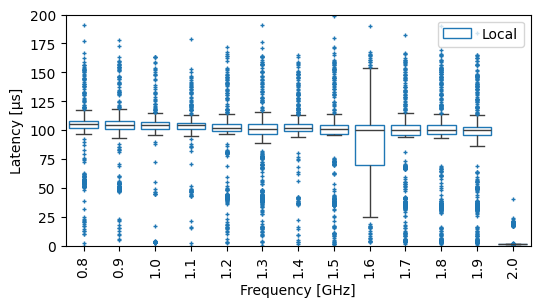

In [78]:
import matplotlib.patches as mpatches
from pylab import rcParams

rcParams['figure.figsize'] = 6, 3

sns.set_palette('tab10')
palette = sns.color_palette()

legend_labels = []

for i, locality in enumerate(df[df.state == 3]["locality"].unique()):
    print(locality)
    legend_labels.append(locality)
    df2=df[df.state == 3]
    df2=df2[df2.locality == locality]
    kwargs = {
        "flierprops": {
            "marker": "+",
            "markersize": 3,
            "markerfacecolor": "None",
            "markeredgecolor": palette[i]
            #"linestyle": "-"
        },
        "linewidth": 1.,
        "whis": 1.5,
    }
    sns.boxplot(
        data=df2,
        x=_frequency,
        y=_time,
        boxprops = { 'linewidth': 1, 'facecolor' : 'white', 'edgecolor': palette[i]},
    **kwargs
    )
legend_patches = [mpatches.Patch(edgecolor=palette[i], facecolor="white", label=label) for i, label in enumerate(legend_labels)]
legend = plt.legend(handles=legend_patches, loc='upper right')

# Set the line colors of the legend patches to match the boxplot lines
# for handle, color in zip(legend.legendHandles, palette):
#     handle.set_edgecolor(color)

plt.rcParams['pdf.fonttype'] = 42
plt.xticks(rotation=90)
plt.gca().set_ylim([0,200])
savefig("../../../thesis/fig/C6_onecolumn")